In [1]:
import os
import random
import pandas as pd
import numpy as np
import copy
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import PIL
import math
import scipy
import gc
from PIL import Image
# !pip install scikit-image
import pydicom
from sklearn import preprocessing 
from sklearn.cluster import KMeans
import tensorflow.keras.backend as K
from skimage import morphology
from skimage import measure
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
import cv2
assert tf.__version__ >= "2.0"
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

PATH = "../input/osic-pulmonary-fibrosis-progression/"
PROCESSED_DATA_PATH = "../input/osic-pulmonary-fibrosis-progression/archive/mask_noise/mask_noise/"
OUTPUT_PATH_LUNG_MASK_IMAGES_1MM = "/Users/paritoshgupta/Desktop/aamlp/aamlp/input/osic-pulmonary-fibrosis-progression/ads/lung_mask_1mm/"
print(f"# Changing directory to {PATH}")
# os.chdir(PATH)
print(f"\n** Files present in PATH --> {list(os.listdir(PATH))}")

new_spacing = [1,1,1]

# Changing directory to ../input/osic-pulmonary-fibrosis-progression/

** Files present in PATH --> ['ads', '.DS_Store', 'archive', 'test', 'test.csv', 'train', 'train.csv', 'sub_df.csv', 'ads_4_folds.csv', 'ads.zip', 'sample_submission.csv']


In [2]:
def load_scan(PATH, patient_type, pat_id):
    path = os.path.join(PATH, patient_type, pat_id)
    images = os.listdir(os.path.join(path))
    images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
    slices = [pydicom.dcmread(os.path.join(path, img)) for img in images]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        try:
            slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)    
        except:
            slice_thickness = np.abs(slices[0].SliceThickness)
    if slice_thickness == 0:
        slice_thickness = 1
    return slices, slice_thickness

def crop_image(img: np.ndarray):
    edge_pixel_value = img[0, 0]
    mask = img != edge_pixel_value
    return img[np.ix_(mask.any(1),mask.any(0))]


def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    if image[0].shape[0] != image[0].shape[1]:
        image = np.stack(crop_image(image[i]) for i in range(image.shape[0]))

    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

# def get_pixels_hu(scans):
    
#     image = np.stack([s.pixel_array for s in scans])
#     image = image.astype(np.int16)
#     if image[0].shape[0] != image[0].shape[1]:
#         image = np.stack(crop_image(image[i]) for i in range(image.shape[0]))

#     # Set outside-of-scan pixels to 0
#     # The intercept is usually -1024, so air is approximately 0
#     image[image == -2000] = 0
    
#     # Convert to Hounsfield units (HU)
#     intercept = scans[0].RescaleIntercept
#     slope = scans[0].RescaleSlope
    
#     if slope != 1:
#         image = slope * image.astype(np.float64)
#         image = image.astype(np.int16)
        
#     image += np.int16(intercept)
    
#     return np.array(image, dtype=np.int16)

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
    
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
 
    # Pick the pixel in the very corner to determine which label is     
     # air.
    # Improvement: Pick multiple background labels from around the   patient
    # More resistant to “trays” on which the patient lays cutting the air around the person in half
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

def resample(image, scan, slice_thickness, new_spacing=[1,1,1]):
    # Determine current pixel spacing
#     spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = map(float, ([slice_thickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor    
    image1 = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    print(f"Spacing Present in DICOM --> {spacing}")
    print(f"Resize Factor --> {resize_factor}")
    print(f"Raw Image Shape --> {image.shape}")    
    print(f"Resampled Image Shape --> {new_real_shape.shape}")    
    print(f"Real Resize Factor --> {real_resize_factor}")    
    print(f"New Spacing --> {new_spacing}")    
    return image1, new_spacing


def min_max_scale(input_image):
    shape = input_image.shape
    scaled_image = preprocessing.minmax_scale(input_image.ravel(), feature_range=(0,255)).reshape(shape)
    return scaled_image

def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img


In [3]:
# PATH = "../input/osic-pulmonary-fibrosis-progression/"
# patient_label="test"
# pat_id = "ID00419637202311204720264"



In [4]:
# # plt.imshow(patient_pixels[0], "gray")
# a = make_lungmask(patient_pixels[4], True)
# plt.imshow(a, "gray")
# patient_dicom = load_scan(PATH, patient_label, pat_id)
# patient_pixels = get_pixels_hu(patient_dicom)


In [5]:
# # isolate lung from chest
# copied_pixels = copy.deepcopy(patient_pixels)
# for i, mask in enumerate(segmented_lungs_fill): 
#     get_high_vals = mask == 0
#     copied_pixels[i][get_high_vals] = 0
# seg_lung_pixels = copied_pixels


In [6]:
# masked_lung_new = [internal_structures[i] for i in range(len(internal_structures)) if np.max(internal_structures[i])> 0]
# print(len(masked_lung_new))           

In [7]:

# try:
#     patient_dicom = load_scan(PATH, patient_label, pat_id)
#     patient_pixels = get_pixels_hu(patient_dicom)
#     masked_lung_scaled = [min_max_scale(img) for img in masked_lung_new]
#     dir_path = os.path.join(output_path, pat_id)
#     os.makedirs(dir_path, exist_ok=True)
#     print(f"** Saving images for Patient --> {pat_id} @ Path --> {dir_path}")
#     for i, lung_img in enumerate(masked_lung_scaled):
#         img = Image.fromarray(lung_img)
#         plt.imsave(f'{output_path}/{pat_id}/{i+1}.png', img, cmap='gray')
# except:
#     pass
    

In [8]:
# def create_lung_mask_patient_1mm(path, patients, patient_label, output_path):
#     for pat_id in tqdm(patients): 
#         try:
#             print("\n\n#######################################################")
#             print(f"********** Processing for Patient ID --> {pat_id} **********")
#             patient_dicom = load_scan(PATH, patient_label, pat_id)
#             patient_pixels = get_pixels_hu(patient_dicom)
# # imgs_after_resamp, spacing = resample(imgs_to_process, patient, st, resample_size)
#             masked_lung = []
#             for img in tqdm(patient_pixels):
#                 try:
#                     masked_lung.append(make_lungmask(img))
#                 except:
#                     pass
#             masked_lung_new = [masked_lung[i] for i in range(len(masked_lung)) if np.max(masked_lung[i])> 0]
#             print("# Dropping empty images...")
#             print(f"- N Images (Pre --> {len(masked_lung)}, Post --> {len(masked_lung_new)})")
#             print("# Min Max Scaling to get values between 0 and 255")
#             masked_lung_scaled = [min_max_scale(img) for img in masked_lung_new]
#             dir_path = os.path.join(output_path, pat_id)
#             os.makedirs(dir_path, exist_ok=True)
#             print(f"** Saving images for Patient --> {pat_id} @ Path --> {dir_path}")
#             for i, lung_img in enumerate(masked_lung_scaled):
#                 img = Image.fromarray(lung_img)
#                 plt.imsave(f'{output_path}/{pat_id}/{i+1}.png', img, cmap='gray')
#             print("#######################################################")
#         except:
#             pass

        
def create_lung_mask_patient_1mm_old(path, patients, patient_label, output_path, resample_size):
    for pat_id in tqdm(patients): 
        try:
            print("\n\n#######################################################")
            print(f"********** Processing for Patient ID --> {pat_id} **********")
            patient, st = load_scan(path, patient_label, pat_id)
            imgs_to_process = get_pixels_hu(patient)
            imgs_after_resamp, spacing = resample(imgs_to_process, patient, st, resample_size)
            masked_lung = []
            for img in tqdm(imgs_after_resamp):
                try:
                    masked_lung.append(make_lungmask(img))
                except:
                    pass
            masked_lung_new = [masked_lung[i] for i in range(len(masked_lung)) if np.max(masked_lung[i])> 0]
            print("# Dropping empty images...")
            print(f"- N Images (Pre --> {len(masked_lung)}, Post --> {len(masked_lung_new)})")
            print("# Min Max Scaling to get values between 0 and 255")
            masked_lung_scaled = [min_max_scale(img) for img in masked_lung_new]
            dir_path = os.path.join(output_path, pat_id)
            os.makedirs(dir_path, exist_ok=True)
            print(f"** Saving images for Patient --> {pat_id} @ Path --> {dir_path}")
            for i, lung_img in enumerate(masked_lung_scaled):
                img = Image.fromarray(lung_img)
                plt.imsave(f'{output_path}/{pat_id}/{i+1}.png', img, cmap='gray')
            print("#######################################################")
        except:
            pass
            

In [9]:
patients_train = [
"ID00094637202205333947361",
"ID00086637202203494931510",
"ID00014637202177757139317",
"ID00067637202189903532242",
"ID00240637202264138860065",
"ID00122637202216437668965"]

patients_test = ["ID00419637202311204720264"]

resample_size = [1,1,1]

output_path = "/Users/paritoshgupta/Desktop/pats_7_new_images/"


In [10]:
create_lung_mask_patient_1mm_old(PATH, patients_test, "test", output_path, resample_size)



#######################################################
********** Processing for Patient ID --> ID00419637202311204720264 **********


/Users/paritoshgupta/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Spacing Present in DICOM --> [10.        0.820312  0.820312]
Resize Factor --> [10.        0.820312  0.820312]
Raw Image Shape --> (28, 512, 512)
Resampled Image Shape --> (3,)
Real Resize Factor --> [10.         0.8203125  0.8203125]
New Spacing --> [1.         0.99999939 0.99999939]



# Dropping empty images...
- N Images (Pre --> 280, Post --> 280)
# Min Max Scaling to get values between 0 and 255
** Saving images for Patient --> ID00419637202311204720264 @ Path --> /Users/paritoshgupta/Desktop/pats_7_new_images/ID00419637202311204720264
#######################################################



In [11]:
create_lung_mask_patient_1mm_old(PATH, patients_train, "train", output_path, resample_size)



#######################################################
********** Processing for Patient ID --> ID00094637202205333947361 **********


/Users/paritoshgupta/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Spacing Present in DICOM --> [10.        0.703125  0.703125]
Resize Factor --> [10.        0.703125  0.703125]
Raw Image Shape --> (24, 512, 512)
Resampled Image Shape --> (3,)
Real Resize Factor --> [10.        0.703125  0.703125]
New Spacing --> [1. 1. 1.]



# Dropping empty images...
- N Images (Pre --> 240, Post --> 167)
# Min Max Scaling to get values between 0 and 255
** Saving images for Patient --> ID00094637202205333947361 @ Path --> /Users/paritoshgupta/Desktop/pats_7_new_images/ID00094637202205333947361
#######################################################


#######################################################
********** Processing for Patient ID --> ID00086637202203494931510 **********


/Users/paritoshgupta/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Spacing Present in DICOM --> [10.        0.669922  0.669922]
Resize Factor --> [10.        0.669922  0.669922]
Raw Image Shape --> (30, 512, 512)
Resampled Image Shape --> (3,)
Real Resize Factor --> [10.          0.66992188  0.66992188]
New Spacing --> [1.         1.00000019 1.00000019]



# Dropping empty images...
- N Images (Pre --> 300, Post --> 300)
# Min Max Scaling to get values between 0 and 255
** Saving images for Patient --> ID00086637202203494931510 @ Path --> /Users/paritoshgupta/Desktop/pats_7_new_images/ID00086637202203494931510
#######################################################


#######################################################
********** Processing for Patient ID --> ID00014637202177757139317 **********


/Users/paritoshgupta/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Spacing Present in DICOM --> [10.        0.798828  0.798828]
Resize Factor --> [10.        0.798828  0.798828]
Raw Image Shape --> (31, 512, 512)
Resampled Image Shape --> (3,)
Real Resize Factor --> [10.          0.79882812  0.79882812]
New Spacing --> [1.         0.99999984 0.99999984]



# Dropping empty images...
- N Images (Pre --> 310, Post --> 246)
# Min Max Scaling to get values between 0 and 255
** Saving images for Patient --> ID00014637202177757139317 @ Path --> /Users/paritoshgupta/Desktop/pats_7_new_images/ID00014637202177757139317
#######################################################


#######################################################
********** Processing for Patient ID --> ID00067637202189903532242 **********


/Users/paritoshgupta/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Spacing Present in DICOM --> [1.       0.871094 0.871094]
Resize Factor --> [1.       0.871094 0.871094]
Raw Image Shape --> (319, 512, 512)
Resampled Image Shape --> (3,)
Real Resize Factor --> [1.         0.87109375 0.87109375]
New Spacing --> [1.         1.00000029 1.00000029]



# Dropping empty images...
- N Images (Pre --> 319, Post --> 319)
# Min Max Scaling to get values between 0 and 255
** Saving images for Patient --> ID00067637202189903532242 @ Path --> /Users/paritoshgupta/Desktop/pats_7_new_images/ID00067637202189903532242
#######################################################


#######################################################
********** Processing for Patient ID --> ID00240637202264138860065 **********


/Users/paritoshgupta/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Spacing Present in DICOM --> [10.        0.742188  0.742188]
Resize Factor --> [10.        0.742188  0.742188]
Raw Image Shape --> (33, 512, 512)
Resampled Image Shape --> (3,)
Real Resize Factor --> [10.         0.7421875  0.7421875]
New Spacing --> [1.         1.00000067 1.00000067]



# Dropping empty images...
- N Images (Pre --> 330, Post --> 327)
# Min Max Scaling to get values between 0 and 255
** Saving images for Patient --> ID00240637202264138860065 @ Path --> /Users/paritoshgupta/Desktop/pats_7_new_images/ID00240637202264138860065
#######################################################


#######################################################
********** Processing for Patient ID --> ID00122637202216437668965 **********


/Users/paritoshgupta/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


Spacing Present in DICOM --> [5.       0.802734 0.802734]
Resize Factor --> [5.       0.802734 0.802734]
Raw Image Shape --> (71, 512, 512)
Resampled Image Shape --> (3,)
Real Resize Factor --> [5.         0.80273438 0.80273438]
New Spacing --> [1.         0.99999953 0.99999953]



# Dropping empty images...
- N Images (Pre --> 355, Post --> 346)
# Min Max Scaling to get values between 0 and 255
** Saving images for Patient --> ID00122637202216437668965 @ Path --> /Users/paritoshgupta/Desktop/pats_7_new_images/ID00122637202216437668965
#######################################################



In [321]:
# pat_id = "ID00419637202311204720264"
# patient_type="test"
# path = os.path.join(PATH, patient_type, pat_id)
# images = os.listdir(os.path.join(path))
# images = sorted(images,key=lambda x: int(os.path.splitext(x)[0]))
# slices = [pydicom.dcmread(os.path.join(path, img)) for img in images]
# slices.sort(key = lambda x: int(x.InstanceNumber))
# slices = [s for s in slices if 'SliceLocation' in s]
# slices.sort(key = lambda x: int(x.InstanceNumber))
# try:
#     slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
# except:
#     slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
# for s in slices:
#     s.SliceThickness = slice_thickness


In [322]:
# image = np.stack([s.pixel_array for s in slices])
# image = image.astype(np.int16)
# image.shape  

(28, 1100, 888)

In [323]:
# def crop_image(img: np.ndarray):
#     edge_pixel_value = img[0, 0]
#     mask = img != edge_pixel_value
#     return img[np.ix_(mask.any(1),mask.any(0))]


In [324]:
# if image[0].shape[0] != image[0].shape[1]:
#     image = np.stack(crop_image(image[i]) for i in range(image.shape[0]))


/Users/paritoshgupta/miniconda3/envs/ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [325]:
# image.shape

(28, 512, 512)

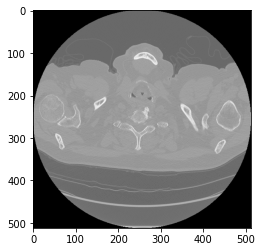

In [326]:
# plt.imshow(image[0], "gray")

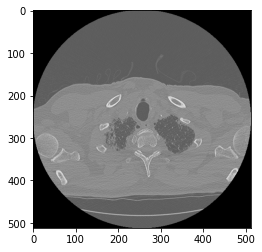

In [244]:
# plt.imshow(crop_image(image[0]), "gray")

In [216]:
# imgs = []

# for i in range(len(image)):
#     if image[i].shape[0] !=image[i].shape[1]:
#         imgs.append(crop_image(image[i]))
    

In [245]:
# if image[0].shape[0] != image[0].shape[1]:
#     for i in range(image.shape[0]):
#         imgs = np.stack([crop_image(image[i])])
#         imgs = imgs.astype(np.int16)
# #         image = imgs

IndexError: index 1 is out of bounds for axis 0 with size 1